In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


2024-05-06 05:03:24.814683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 05:03:24.814785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 05:03:24.944882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
import cv2

def resize_images(folder_path, target_size):
    # Get list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    for image_file in image_files:
        # Read the image
        image_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_path)
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        
        # Save the resized image back
        cv2.imwrite(image_path, resized_img)
        print(f"{image_file} resized to {target_size}")

# Specify the target size
target_size = (256, 256)  # Specify the dimensions you want, e.g., (width, height)

# Paths to the folders containing images
folder1_path = "BirdVsDrone/Birds"
folder2_path = "BirdVsDrone/Drones"

# Resize images in the first folder
resize_images(folder1_path, target_size)

# Resize images in the second folder
resize_images(folder2_path, target_size)

In [3]:
IMAGE_WIDTH = 416
IMAGE_HEIGHT = 416
BATCH_SIZE = 32

In [4]:
train_data_dir = "/kaggle/input/dronesnew/Train"
val_data_dir = "/kaggle/input/dronesnew/Val"
test_data_dir = "/kaggle/input/dronesnew/Test"

In [6]:
img_width, img_height = 256, 256
batch_size = 32
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2866 images belonging to 2 classes.
Found 796 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [17]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [19]:
# Create a new model with additional layers for classification
from tensorflow.keras.models import Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Added Dropout layer
x = Dense(256, activation='relu')(x)  # Added layer
x = Dropout(0.5)(x)  # Added Dropout layer
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 8,005,506 (30.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/50







20/20 [==============================] - 64s 3s/step - loss: 0.4141 - accuracy: 0.7978 - val_loss: 0.2948 - val_accuracy: 0.8693

Epoch 2/50

20/20 [==============================] - 48s 2s/step - loss: 0.2163 - accuracy: 0.9092 - val_loss: 0.2208 - val_accuracy: 0.8945

Epoch 3/50

20/20 [==============================] - 47s 2s/step - loss: 0.1549 - accuracy: 0.9347 - val_loss: 0.1824 - val_accuracy: 0.9196

Epoch 4/50

20/20 [==============================] - 48s 2s/step - loss: 0.1159 - accuracy: 0.9618 - val_loss: 0.1673 - val_accuracy: 0.9246

Epoch 5/50

20/20 [==============================] - 49s 2s/step - loss: 0.1173 - accuracy: 0.9522 - val_loss: 0.1485 - val_accuracy: 0.9296

Epoch 6/50

20/20 [==============================] - 48s 2s/step - loss: 0.1156 - accuracy: 0.9538 - val_loss: 0.1447 - val_accuracy: 0.9246

Epoch 7/50

20/20 [==============================] - 51s 3s/step - loss: 0.0754 - accuracy: 0.9697 - val_loss: 0.1468 - val_accuracy: 0.9347



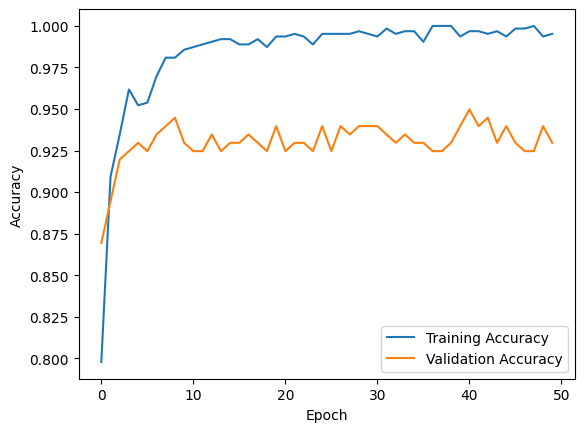

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model.save('dense.h5')

C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [12]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

7/7 [==============================] - 11s 2s/step - loss: 0.1784 - accuracy: 0.9296

Validation Accuracy: 92.96%

Validation Loss: 0.1784


In [14]:
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

7/7 [==============================] - 13s 2s/step


In [2]:
from sklearn.metrics import classification_report

# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Classification report
print(classification_report(true_labels, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.90      0.95       299
           1       0.87      0.98      0.95       298

    accuracy                           0.94       597
   macro avg       0.87      0.94      0.95       597
weighted avg       0.87      0.94      0.95       597



Confusion Matrix:
[[289  10]
 [  0 298]]


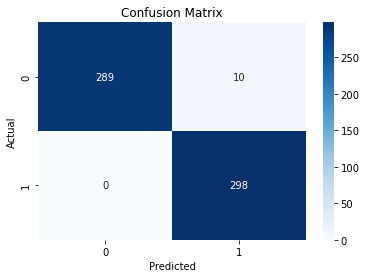

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 2s 2s/step


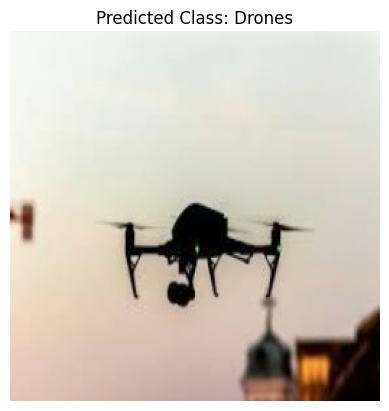

In [27]:
test_image_path = 'Val/Drones/singleDronesinsky290.jpeg'  # Replace with the path to your test image
img = image.load_img(test_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# Map class index to class label
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_label = class_labels[predicted_class]

# Display the image and predicted class label
img = mpimg.imread(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_label}")
plt.show()